<img src="./sharif.png" alt="SUT logo" width=300 height=300 align=left class="saturate">

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3<br>
<font color=696880 size=4>
    Ashkan Majidi - Shayan Salehi - Amirhossein Alamdar

____

# Personal Data

In [14]:
student_number = '99100036'
first_name = 'Hooman'
last_name = 'Zolfaghari'

# Introduction

In this assignment, you will implement SVM (Support Vector Machines) for classification.


# Data Prepfocessing

Import your needed libraries in following cell.

In [15]:
# TODO: Write your code here
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import cvxopt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

Load data from ```satimage``` dataset and split data to features and labels. The ```label``` column is our target variable.

In [16]:
# TODO: Write your code here
df = pd.read_csv("/content/satimage.csv")
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,[-1]].to_numpy().flatten()
#X = df.drop(columns=['label'])
#y = df['label']


Now split data to train, validation and test parts. 60% of data should be used for train, 15% for validation and 25% for test. After that scale the data to Standard Normal Distribution using ```StandardScaler``` class from ```scikit-learn``` library.

In [17]:
# TODO: Write your code here
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=5)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.625, random_state=5)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

We want to train Binary SVM model for classification between labels 4 and 6. Choose corresponding datas and convert their lables to 1 and -1 respectively for 4 and 6.

In [18]:
# TODO: Write your code here
relevant_indices = (y_train == 4) | (y_train == 6)
X_relevant_train = X_train_scaled[relevant_indices]
y_relevant_train = y_train[relevant_indices]

test_relevant_indices = (y_test == 4) | (y_test == 6)
X_relevant_test = X_test_scaled[test_relevant_indices]
y_relevant_test = y_test[test_relevant_indices]

val_relevant_indices = (y_val == 4) | (y_val == 6)
X_relevant_val = X_val_scaled[val_relevant_indices]
y_relevant_val = y_val[val_relevant_indices]

label_encoder = LabelEncoder()

y_binary_train = label_encoder.fit_transform(y_relevant_train)
y_binary_train = 2 * y_binary_train - 1

y_binary_val = label_encoder.fit_transform(y_relevant_val)
y_binary_val = 2 * y_binary_val - 1

y_binary_test = label_encoder.fit_transform(y_relevant_test)
y_binary_test = 2 * y_binary_test - 1

# Model (50 points)

Here is soft margin svm convex optimization formulation.
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2}\|\mathbf{w}\|^2+C \sum_{i=1}^N \xi_i \\
\text { Subject to } & y_i\left(\mathbf{w}^T \mathbf{x}_i+b\right) \geq 1-\xi_i, \quad i=1,2, \ldots, N \\
& \xi_i \geq 0, \quad i=1,2, \ldots, N
\end{aligned}
$$
write dual of the soft margin svm optimization problem below:

`TODO: Write Here` \\
Lagrange formulation:
$$
\begin{align}
\text { Minimize } & 𝓛\left(\mathbf{w},w_0,ξ,α,β\right) =
 \frac{1}{2}\|\mathbf{w}\|^2+C \sum_{i=1}^N \xi_i \\
 & + ∑_{i=1}^N α_i\left(1 - ξ_i - y_i\left(\mathbf{w}^T \mathbf{x}_i+b\right)\right)
- ∑_{i=1}^N β_iξ_i, \quad i=1,2, \ldots, N \\
& \text{ w.r.t } \mathbf{w},\, w_0, \, ξ \text{ and maximize w.r.t } α_i \geq 0 \text{ and } β_i \geq 0
\end{align}
$$
dual problem:
$$
\begin{equation}
\text{Maximize }\tilde{𝓛}\left(\mathbf{w},w_0,ξ,α,β\right) = \sum_{i=1}^N α_i - \frac{1}{2}
\sum_{n=1}^{N}\sum_{m=1}^{N} α_nα_my_ny_mk(\mathbf{x}_n,\mathbf{x}_m) \\
 \text{s.t. } 0 \leqα_i\leq C \text{ and } \sum_{n=1}^N α_iy_i = 0
\end{equation}
$$


Now you should write this optimization problem in standard Quadratic Program (QP) form and use a QP solver to find optimal answer. Here is General form of a QP:
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2} x^TPx + q^Tx + r \\
\text { Subject to } & Gx \leq h \\
& Ax = b
\end{aligned}
$$

Complete functions below and use ```cvxopt``` library which is a common library for solving QPs. Note that you can't use ```scikit-learn``` library.


In [19]:
def soft_margin_svm(X, y, C):
    """
    input:
        X: training data
        y: training labels
        C: errors weight
    output:
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs
    """

    # TODO: Write your code here

    n_samples, n_features = X.shape

    y = y.reshape(-1,1) * 1.
    X_dash = y * X

    #print(f"P:{(np.dot(X_dash,X_dash.T)* 1.).shape}\n{np.dot(X_dash,X_dash.T)* 1.}")

    P = cvxopt.matrix(np.dot(X_dash,X_dash.T)* 1.)
    q = cvxopt.matrix(-1 * np.ones((n_samples)))

    t1 = np.diag(-1 * np.ones(n_samples))
    t2 = np.identity(n_samples)
    G = cvxopt.matrix(np.vstack((t1,t2)))

    h = cvxopt.matrix(np.hstack((np.zeros(n_samples), C * np.ones(n_samples))))

    A = cvxopt.matrix(y,(1,n_samples))
    #print(f"A:{A}")
    b = cvxopt.matrix(0.0)

    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    alphas = np.ravel(solution['x'])
    support_vector_indices = np.where(alphas > 1e-5)[0]
    support_vectors = X[support_vector_indices]
    support_vector_labels = y[support_vector_indices]
    support_vector_alphas = alphas[support_vector_indices]

    return support_vectors, support_vector_labels, support_vector_alphas


In [20]:
C = 1.0
support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(X_relevant_train, y_binary_train, C)

     pcost       dcost       gap    pres   dres
 0: -6.2865e+02 -3.4385e+03  2e+04  3e+00  2e-13
 1: -4.2983e+02 -2.3323e+03  3e+03  4e-01  2e-13
 2: -4.0296e+02 -8.0356e+02  5e+02  3e-02  1e-13
 3: -4.4928e+02 -5.7694e+02  1e+02  9e-03  1e-13
 4: -4.6589e+02 -5.4623e+02  9e+01  5e-03  1e-13
 5: -4.7748e+02 -5.2343e+02  5e+01  2e-03  1e-13
 6: -4.8745e+02 -5.0520e+02  2e+01  6e-04  1e-13
 7: -4.9168e+02 -4.9839e+02  7e+00  1e-04  1e-13
 8: -4.9315e+02 -4.9624e+02  3e+00  5e-05  1e-13
 9: -4.9416e+02 -4.9490e+02  8e-01  8e-06  1e-13
10: -4.9444e+02 -4.9455e+02  1e-01  8e-07  2e-13
11: -4.9448e+02 -4.9450e+02  2e-02  1e-07  1e-13
12: -4.9449e+02 -4.9449e+02  8e-04  2e-16  2e-13
13: -4.9449e+02 -4.9449e+02  1e-05  6e-15  2e-13
Optimal solution found.


In [23]:
def predict_labels(x_test, support_vectors, support_vector_labels, support_vector_alphas):
    """
    input:
        x_test: test data
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs
    output:
        y_pred: predictoin labels
    """
    # TODO: Write your code here
    #w = np.dot((support_vector_alphas * support_vector_labels).reshape(1,-1), support_vectors).flatten()
    w = np.zeros(x_test.shape[1])
    for n in range(len(support_vector_alphas)):
        w += support_vector_alphas[n] * support_vector_labels[n] * support_vectors[n]

    Kb = np.zeros((len(support_vectors),len(support_vectors)))
    for i in range(len(support_vectors)):
      for j in range(len(support_vectors)):
        Kb[i][j] = np.dot(support_vectors[i],support_vectors[j])
    b = 0
    for n in range(len(support_vectors)):
      b = b + support_vector_labels[n]
      b -= np.sum((support_vector_alphas * support_vector_labels.flatten()) * Kb[i])
    b = b / len(support_vectors)

    y_pred = np.dot(x_test,w) + b

    return np.sign(y_pred)

In [24]:
y_pred = predict_labels(np.array(X_relevant_test), support_vectors, support_vector_labels, support_vector_alphas)

# Evaluation (20 points)

Compute accuracy, balanced accuracy and plot confusion matrix of your trained model using ```Seaborn.heatmap()``` function. Use case of balanced accuracy is when dealing with imbalanced data, i.e. when one of the target classes appears a lot more than the other and it is defined by average of recall of classes. Confusion matrix is a $k\times k$ (k is number of classes) matrix which cell ij is showing that number of data points labeld i which predicted j. For more detail of evaluation metrics you can see [here](https://neptune.ai/blog/balanced-accuracy).

You may use ```scikit-learn``` library to compute these metrics.

In [25]:
def evaluate(y_test, y_pred):
    """
    input:
        y_test: true labels
        y_pred: predicted labels
    output:
        accuracy: accuracy of the model
        balanced_accuracy: balanced accuracy of the model
        confusion_matrix: confusion matrix of the model
    """
    # TODO: Write your code here

    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    print("Accuracy: ", accuracy)
    print("Balanced Accuracy: ", balanced_accuracy)
    print("Confusion Matrix:\n", confusion_mat)


    return accuracy, balanced_accuracy, confusion_mat



_, _, confusion_mat = evaluate(y_binary_test, y_pred)

Accuracy:  0.83203125
Balanced Accuracy:  0.8160856901249648
Confusion Matrix:
 [[113  32]
 [ 54 313]]


<Axes: >

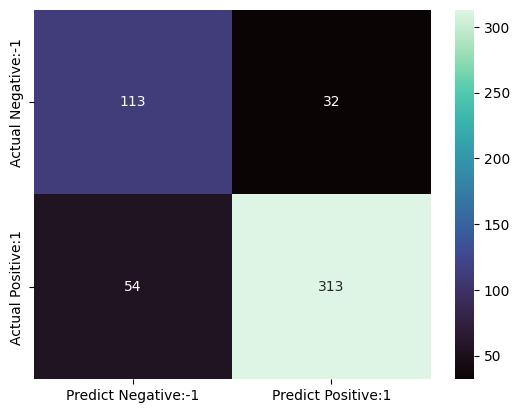

In [26]:
cm_matrix = pd.DataFrame(data=confusion_mat, columns=['Predict Negative:-1', 'Predict Positive:1'],
                                 index=['Actual Negative:-1', 'Actual Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')

# Fine-tunning (40 points)

like what you did before, implement Soft Margin SVM but now use rbf kernel. To determine rbf $\gamma$ parameter use validation datas and find best(best by balanced accuracy) $\gamma$ between 0.001 , 0.01, 1, 10, 100. Not that you can't use ```scikit-learn``` library here.

In [27]:
def rbf(x1, x2, gamma=1):
    """
    input:
        x1: first vector
        x2: second vector
        gamma: rbf kernel parameter with defalt value 1.
    output:
        ouput: computed rbf of two input vectors
    """
    distance = np.linalg.norm(x1 - x2)
    output = np.exp(-gamma * distance**2)
    return output

def soft_margin_svm_rbf(X, y, C, gamma=1):
    """
    input:
        X: training data
        y: training labels
        C: errors weight
        gamma: rbf kernel parameter with defalt value 1.
    output:
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs
    """

    # TODO: Write your code here

    n_samples, n_features = X.shape

    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
      for j in range(n_samples):
        K[i, j] = rbf(X[i],X[j], gamma)

    #print(f"P:{(np.outer(y,y)*K).shape}\n{np.outer(y,y)*K}")

    P = cvxopt.matrix(np.outer(y,y)*K)
    q = cvxopt.matrix(-1 * np.ones((n_samples)))

    t1 = np.diag(-1 * np.ones(n_samples))
    t2 = np.identity(n_samples)
    G = cvxopt.matrix(np.vstack((t1,t2)))

    h = cvxopt.matrix(np.hstack((np.zeros(n_samples), C * np.ones(n_samples))))

    A = cvxopt.matrix(y*1.,(1,n_samples))
    #print(f"A:{A}")
    b = cvxopt.matrix(0.0)

    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    alphas = np.ravel(solution['x'])
    support_vector_indices = np.where(alphas > 1e-5)[0]
    support_vectors = X[support_vector_indices]
    support_vector_labels = y[support_vector_indices]
    support_vector_alphas = alphas[support_vector_indices]

    return support_vectors, support_vector_labels, support_vector_alphas

def predict_rbf(x_test, support_vectors, support_vector_labels, support_vector_alphas,gamma=1):

    # for x in x_test:
    #   K = np.zeros(len(support_vectors))
    #   for i in range(len(support_vectors)):
    #     K[i] = rbf(support_vectors[i],x)
    # y_pred = np.dot((support_vector_alphas * support_vector_labels).reshape(1,-1), K).flatten()
    y_predict = np.zeros(len(x_test))
    for i in range(len(x_test)):
      s = 0
      for a, sv_y, sv in zip(support_vector_alphas, support_vector_labels, support_vectors):
          s += a * sv_y * rbf(x_test[i], sv,gamma)
      y_predict[i] = s

    Kb = np.zeros((len(support_vectors),len(support_vectors)))
    for i in range(len(support_vectors)):
      for j in range(len(support_vectors)):
        Kb[i][j] = rbf(support_vectors[i],support_vectors[j],gamma)
    b = 0
    for n in range(len(support_vectors)):
      b = b + support_vector_labels[n]
      b -= np.sum((support_vector_alphas * support_vector_labels.flatten()) * Kb[i])
    b = b / len(support_vectors)

    return np.sign(y_predict + b)



In [28]:
gammas = [0.001, 0.01, 1, 10, 100]
best_gamma = None
best_support_vectors = None
best_support_vector_labels = None
best_support_vector_alphas = None

# TODO: Write your code here
balanced_accuracies = []
best_balanced_accuracy = 0
best_gamma = None
for gamma in gammas:
  print(f"gamma:{gamma}")
  C = 1.0
  support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm_rbf(X_relevant_train, y_binary_train, C, gamma)
  y_pred_val = predict_rbf(X_relevant_val,support_vectors, support_vector_labels, support_vector_alphas, gamma)

  ba = balanced_accuracy_score(y_binary_val, y_pred_val)
  if ba > best_balanced_accuracy :
     best_balanced_accuracy = ba
     best_gamma = gamma
     best_support_vector_alphas = support_vector_alphas
     best_support_vector_labels = support_vector_labels
     best_support_vectors = support_vectors

print(f"best_gamma:{best_gamma}")

gamma:0.001
     pcost       dcost       gap    pres   dres
 0: -6.7874e+02 -3.1400e+03  1e+04  3e+00  2e-14
 1: -4.5867e+02 -2.0330e+03  2e+03  8e-02  2e-14
 2: -5.2247e+02 -7.8008e+02  3e+02  1e-02  1e-14
 3: -5.9276e+02 -6.5874e+02  7e+01  2e-03  2e-14
 4: -6.0930e+02 -6.3583e+02  3e+01  7e-04  2e-14
 5: -6.1790e+02 -6.2451e+02  7e+00  1e-04  2e-14
 6: -6.2049e+02 -6.2127e+02  8e-01  8e-06  2e-14
 7: -6.2081e+02 -6.2090e+02  9e-02  4e-07  2e-14
 8: -6.2085e+02 -6.2086e+02  6e-03  2e-08  2e-14
 9: -6.2085e+02 -6.2085e+02  3e-04  1e-09  2e-14
Optimal solution found.
gamma:0.01
     pcost       dcost       gap    pres   dres
 0: -5.9426e+02 -3.1900e+03  2e+04  3e+00  2e-14
 1: -4.2061e+02 -2.0627e+03  2e+03  2e-01  1e-14
 2: -4.3642e+02 -7.5981e+02  4e+02  3e-02  1e-14
 3: -4.8901e+02 -5.9705e+02  1e+02  7e-03  1e-14
 4: -5.0704e+02 -5.6354e+02  6e+01  3e-03  1e-14
 5: -5.1778e+02 -5.4411e+02  3e+01  1e-03  1e-14
 6: -5.2477e+02 -5.3284e+02  8e+00  3e-04  1e-14
 7: -5.2670e+02 -5.2991e

In [29]:
y_pred = predict_rbf(X_relevant_test, best_support_vectors, best_support_vector_labels, best_support_vector_alphas,best_gamma)
_, _, confusion_mat = evaluate(y_binary_test, y_pred)

Accuracy:  0.833984375
Balanced Accuracy:  0.8070186977356009
Confusion Matrix:
 [[108  37]
 [ 48 319]]


# Multiclass SVM (30 points + 50 points optional)

Now we want implement Multiclass SVM. Use ```SVC``` function with rbf kernel from ```scikit-learn``` package on all train datas (all six classes) and choose best hyperparameters for $C$ and $\gamma$ between 0.01, 0.1, 1, 10, 100. After that evaluate it with your function.

Note that in this example we had enough data to split them in train and validation but in case that we don't have enough data, ```scikit-learn``` has a built-in fast library named ```GridSearchCV()``` which can help us in hyperparameter tunning with cross validation.

In [30]:
from sklearn import svm

In [31]:
Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.01, 0.1, 1, 10, 100]
# TODO: Write your code here
bestC = None
bestGamma = None
best_accuracy = 0;
for c in Cs:
  for gamma in gammas:
    rbfsvm = svm.SVC(kernel='rbf',C = c, gamma = gamma)
    rbfsvm.fit(X_train_scaled, y_train)
    y_pred = rbfsvm.predict(X_val_scaled)
    acc = balanced_accuracy_score(y_val,y_pred)
    if acc > best_accuracy:
       best_accuracy = acc
       bestC = c
       bestGamma = gamma

bestRbfSvm = svm.SVC(kernel='rbf',C = bestC, gamma = bestGamma)
bestRbfSvm.fit(X_train_scaled,y_train)
y_pred = bestRbfSvm.predict(X_test_scaled)

evaluate(y_test=y_test,y_pred=y_pred)


Accuracy:  0.9142324425108763
Balanced Accuracy:  0.8852709524812351
Confusion Matrix:
 [[390   0   5   0   0   0]
 [  0 188   0   3   3   0]
 [  1   2 306  10   1   6]
 [  1   2  36  83   3  20]
 [  0   4   0   1 170   7]
 [  0   0   8  14  11 334]]


(0.9142324425108763,
 0.8852709524812351,
 array([[390,   0,   5,   0,   0,   0],
        [  0, 188,   0,   3,   3,   0],
        [  1,   2, 306,  10,   1,   6],
        [  1,   2,  36,  83,   3,  20],
        [  0,   4,   0,   1, 170,   7],
        [  0,   0,   8,  14,  11, 334]]))

Implement Multiclass SVM from scratch without using ready functions (optional).

In [ ]:
# TODO: Write your code here

# Different SVM Kernels (40 points)

A kernel in SVM is like a tool that helps solve tricky problems. It lets us work in a space with many dimensions, making complex calculations easier. With kernels, we can deal with lots of dimensions, even an endless amount. Kernels are crucial for sorting data into groups and help spot patterns in the data we're looking at. They're especially good at tackling twisty problems with a straightforward approach.

Sometimes, finding a straight line or flat surface to divide data isn't possible, especially as we explore more dimensions. That's where different types of SVM kernels come in handy. They transform twisty, complicated data into a simpler form that's easier to separate. In this explanation, we talk about 4 popular types of these kernels. Also in following cells you can use any package.

<img src="./kernel.jpg" alt="Types of Kernel Functions"  align=center class="saturate">

In [32]:
from sklearn import svm

### Linear Kernel

This is the simplest kind of kernel, typically working in one dimension. It works best when dealing with a lot of features. Linear kernels are quicker than other types.

**Formula:**

$$F(x, x_j) = sum(x, x_j)$$

Now Implement svc classifier using a linear kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix by `Seaborn`.

In [33]:
X_evaluation = np.vstack((X_val_scaled,X_test_scaled))
y_evaluation = np.hstack((y_val,y_test))

Accuracy:  0.8609168609168609
Balanced Accuracy:  0.8225907884178353
Confusion Matrix:
 [[608   0  11   0   6   0]
 [  0 268   0   1  22   0]
 [  4   1 481  36   1   2]
 [  3   2  54 112   6  68]
 [  5  16   1   2 222  26]
 [  0   0  12  62  17 525]]


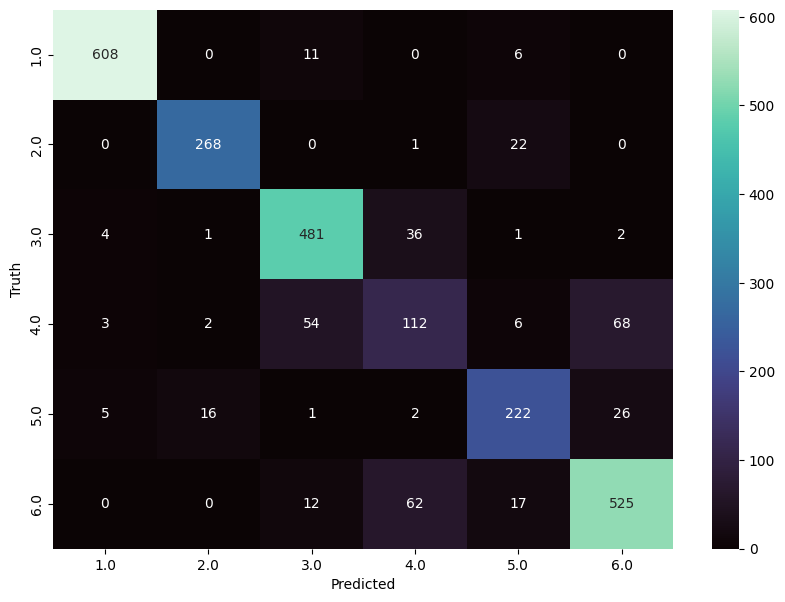

In [34]:
# TODO: Write your code here
linearSvm = svm.SVC(kernel = "linear")
linearSvm.fit(X_train_scaled,y_train)
y_pred = linearSvm.predict(X_evaluation)
_,_,cm = evaluate(y_pred=y_pred,y_test = y_evaluation)

cm_matrix = pd.DataFrame(data=cm, columns= linearSvm.classes_,
                                index= linearSvm.classes_)
#sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')
plt.figure(figsize=(10,7))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap = 'mako')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Gaussian RBF kernel

This kernel is a favorite choice in SVM, especially for data that doesn't line up straight. It's great for sorting data when you don't know much about it beforehand.

**Formula:**

$$F(x, x_j) = \exp{(-\gamma ||x - xj||^2)}$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous part.

Accuracy:  0.8974358974358975
Balanced Accuracy:  0.8709301728251438
Confusion Matrix:
 [[612   1  10   0   2   0]
 [  0 281   1   3   5   1]
 [  3   1 497  15   2   7]
 [  3   2  52 144   3  41]
 [  6   9   1   2 237  17]
 [  0   0  12  56   9 539]]


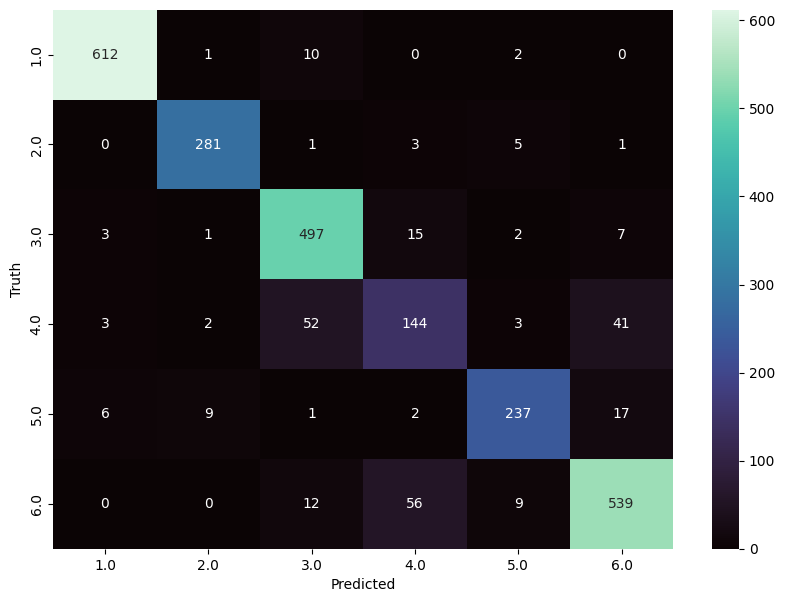

In [35]:
# TODO: Write your code here
rbfSvm = svm.SVC(kernel = "rbf")
rbfSvm.fit(X_train_scaled,y_train)
y_pred = rbfSvm.predict(X_evaluation)
_,_,cm = evaluate(y_pred=y_pred,y_test = y_evaluation)

cm_matrix = pd.DataFrame(data=cm, columns= rbfSvm.classes_,
                                index= rbfSvm.classes_)

plt.figure(figsize=(10,7))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap = 'mako')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Polynomial Kernel

This is a broader version of the linear kernel. It's not as popular because it's not as quick or precise.

**Formula:**

$$F(x, x_j) = (x.x_j+1)^d$$

Now, set up the SVC classifier using a *polynomial* kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts.

Accuracy:  0.8589743589743589
Balanced Accuracy:  0.8306359846031509
Confusion Matrix:
 [[615   1   7   1   1   0]
 [  3 273   0   9   5   1]
 [  7   1 464  40   0  13]
 [ 10   2  35 165   1  32]
 [ 40   8   0  14 184  26]
 [  1   0   5  92   8 510]]


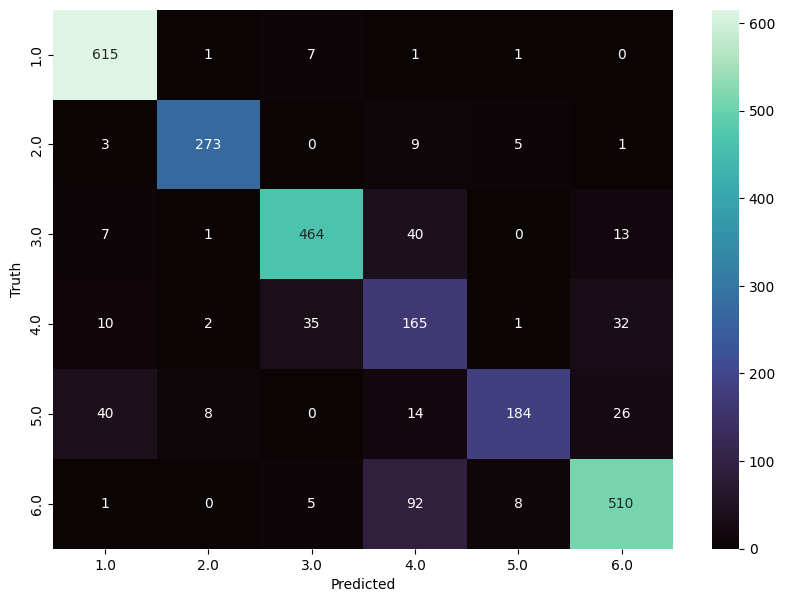

In [36]:
# TODO: Write your code here
plySvm = svm.SVC(kernel = "poly")
plySvm.fit(X_train_scaled,y_train)
y_pred = plySvm.predict(X_evaluation)
_,_,cm = evaluate(y_pred=y_pred,y_test = y_evaluation)

cm_matrix = pd.DataFrame(data=cm, columns= plySvm.classes_,
                                index= plySvm.classes_)

plt.figure(figsize=(10,7))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap = 'mako')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Sigmoid Kernel

This is mainly chosen for use with neural networks. The kernel function acts like the activation function in a two-layer perceptron neural network model, helping to activate the neurons.

**Formula:**

$$F(x, x_j) = \tanh(α x a y + c)$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts.

Accuracy:  0.7202797202797203
Balanced Accuracy:  0.6797588059716233
Confusion Matrix:
 [[504  11  32   0  78   0]
 [ 24 257   0   4   6   0]
 [  3   1 477  40   1   3]
 [  3   4  55  76  24  83]
 [ 23  50   5  41 143  10]
 [  0   0  15  88 116 397]]


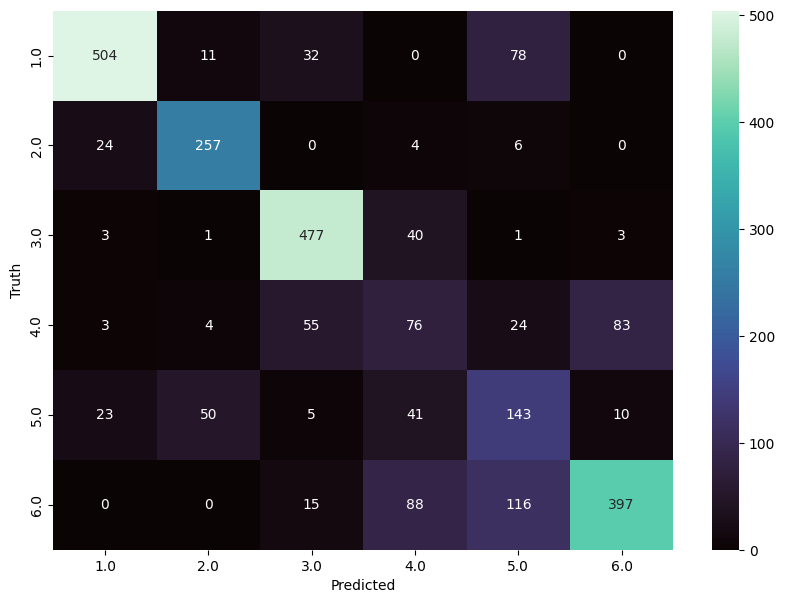

In [37]:
# TODO: Write your code here
sigmoidSVM = svm.SVC(kernel = "sigmoid")
sigmoidSVM.fit(X_train_scaled,y_train)
y_pred = sigmoidSVM.predict(X_evaluation)
_,_,cm = evaluate(y_pred=y_pred,y_test = y_evaluation)

cm_matrix = pd.DataFrame(data=cm, columns= sigmoidSVM.classes_,
                                index= sigmoidSVM.classes_)

plt.figure(figsize=(10,7))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap = 'mako')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

Compare these four kernel functions with each other. What are the main advantages and disadvantages of each one?

`TODO: Write Here`\\

- **Linear**:
    - **Advantages**: It is simple and computationally efficient. It works well when the data is linearly separable.
    - **Disadvantages**: It cannot handle complex datasets that are not linearly separable.

- **RBF**:
    - **Advantages**: It can handle non-linearly separable data well and can create complex decision boundaries. It has fewer hyperparameters to tune (usually just the gamma parameter).
    - **Disadvantages**: It can be computationally expensive for large datasets. It may also overfit if the gamma parameter is not properly tuned.

- **Polynomial**:
    - **Advantages**: It can model non-linear decision boundaries, and you can control the complexity of the decision boundaries by changing the degree of the polynomial.
    - **Disadvantages**: High-degree polynomials can lead to overfitting. It can be computationally expensive for high-degree polynomials.

- **Sigmoid**:
    - **Advantages**: It can provide a proxy for neural networks with one hidden layer.
    - **Disadvantages**: It is not always a valid kernel function as it does not satisfy Mercer's condition in some cases. This can lead to poor performance.

  In the end the choice of kernel function depends on the dataset.
